In [32]:
### Setup ###
import os
import re 
import psutil
import math
import time
import yaml
import shutil
import zipfile
import random
import requests
import cv2
import itertools
import json
import copy
import pickle
import gzip
from IPython.display import display_html
from scipy.spatial import ConvexHull
from scipy.stats import entropy
from tqdm.notebook import tqdm
from PIL import Image
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as mpltPath
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import cv2
import torchvision.transforms as transforms
import folium
import mapclassify
import seaborn as sns

from torchvision.models import resnet50
from PIL import Image
from folium.features import DivIcon
from random import randint
from concurrent.futures import ThreadPoolExecutor
from collections import Counter
from pyproj import Geod
from random import randint
from tqdm import tqdm

### Directories ###
WORK_DIR = "."

### GPU ###
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import torch  
print(torch.cuda.is_available())  
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  Memory Allocated: {torch.cuda.memory_allocated(i)/1024**2:.2f} MB")
        print(f"  Memory Cached:    {torch.cuda.memory_reserved(i)/1024**2:.2f} MB")
else:
    print("No CUDA-compatible GPU detected.")

from ultralytics import YOLO 
#ultralytics.checks()

def install_opencv_headless():
    try:
        subprocess.run(["pip", "install", "opencv-python-headless"], check=True)
        print("opencv-python-headless installed successfully.")
    except subprocess.CalledProcessError as e:
        print(f"An error occurred: {e}")
#install_opencv_headless()


### Import ###
folder_dir = "./img"
filenames = sorted([x for x in os.listdir(folder_dir) if x.endswith(".jpg")])
filenames = [os.path.join(folder_dir, f) for f in filenames]
print("Total files:", len(filenames))
#filenames = filenames[0:100] # subsetting the image files
print("Total files:", len(filenames))

# set batch size (e.g., 1000 per range)
BATCH_SIZE = 1000
MAX_LENGTH = len(filenames)
def generate_ranges(batch_size, max_length=MAX_LENGTH):
    num_batches = math.ceil(max_length / batch_size)
    ranges = []
    for i in range(num_batches):
        start = i * batch_size
        end = min((i + 1) * batch_size, max_length)
        ranges.append(range(start, end))
    return ranges
ranges = generate_ranges(BATCH_SIZE)
print("Number of ranges:", len(ranges))

# create a storage directory of GSV images
output_dir = os.path.join(".", "vehicle_detection") 
os.makedirs(output_dir, exist_ok=True)
os.makedirs(os.path.join(output_dir, "inferred") , exist_ok=True)
print(output_dir)

True
GPU 0: NVIDIA RTX A6000
  Memory Allocated: 420.24 MB
  Memory Cached:    6794.00 MB
Total files: 64
Total files: 64
Number of ranges: 1
./vehicle_detection


In [11]:
### Instance segmentation ###
# load model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = YOLO("yolo11s-seg.pt")
model.to(device)

car_class = 2
SIZE = 1600
MAX_INPUT = 100

# execute
files_to_predict = filenames[0:MAX_INPUT]
results = model.predict(files_to_predict, verbose=False, device=3)

# filter relevant results
for result in results[0:MAX_INPUT]:
    if result.masks:
        car_mask = result.boxes.cls == car_class
        #if car_mask:
            #print(result)
        #print(f"{car_mask.sum()} cars out of {len(car_mask)} objects")
        masks = result.masks[car_mask]
        for mask in masks:
            poly = mask.xy 
            poly = poly[0]

# extract visual features
def preprocess_image(image_array):
    transform = transforms.Compose([
        transforms.ToPILImage(),  # Convert NumPy to PIL
        transforms.Resize((224, 224)),
        transforms.ToTensor(),  # [0,1]
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Imagenet stats
                             std=[0.229, 0.224, 0.225])
    ])
    return transform(image_array).unsqueeze(0)  # Add batch dimension
model = resnet50(pretrained=True)
model.eval()
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])  # removes fc layer

for result in results[0:MAX_INPUT]:
    output_list_eachimg = list()
    basename = os.path.basename(result.path)
    print(basename)
    basename = basename.split(".j")[0]
    output_path = os.path.join(output_dir, "inferred", f"{basename}.pkl")

    if result.masks is None:
        print(f"No car detected")
    if result.masks:
        car_mask = result.boxes.cls == car_class
        print(f"{car_mask.sum()} cars out of {len(car_mask)} objects")
        masks = result.masks[car_mask]
        orig_img = result.orig_img
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)  # OpenCV (cv2) loads images in BGR format by default, not RGB

        for mask_idx, mask in enumerate(masks):
            poly = mask.xy  # your polygon points as a NumPy array, likely float32
            poly = poly[0]
            # Convert to int32
            poly = poly.astype(np.int32)
            # Optionally, reshape to (num_points, 1, 2) if needed:
            poly = poly.reshape((-1, 1, 2))
            empty_mask = np.zeros((640, 640), dtype=np.uint8)
            mask_square = cv2.fillPoly(empty_mask, [poly], 1)
            #print(mask_square)
            #print(f"shape of mask_square: {mask_square.shape}")
            #print(f"sum of mask_square: {mask_square.sum()}")
            masked_img = cv2.bitwise_and(orig_img, orig_img, mask=mask_square)

            #====cropping===#
            y_indices, x_indices = np.where(mask_square == 1)
            if len(x_indices) == 0 or len(y_indices) == 0:
                print("Empty mask after fillPoly — skipping")
                continue
            x_min, x_max = x_indices.min(), x_indices.max()
            y_min, y_max = y_indices.min(), y_indices.max()
            cropped_img = masked_img[y_min:y_max+1, x_min:x_max+1]

            cropped_img_size = cropped_img.shape[0] * cropped_img.shape[1]
            #print(f"cropped_img_size: {cropped_img_size}")
            if cropped_img_size > SIZE:
                #====extracting feature tensor===#
                feature = preprocess_image(cropped_img)  # cropped_img: RGB NumPy array
                with torch.no_grad():
                    feature = feature_extractor(feature)  # shape: [1, 2048, 1, 1]
                feature = feature.view(1, -1)
                #print(feature.shape)  
                #print(feature)
    
                #====saving===#
                output_dict_eachmask = dict()
                output_dict_eachmask["car_px"] = mask_square
                output_dict_eachmask["car_img"] = cropped_img
                output_dict_eachmask["feature"] = feature
                output_list_eachimg.append(output_dict_eachmask)
    #print(output_list_eachimg)

    if len(output_list_eachimg) > 0:    
        with open(output_path, 'wb') as f:
            pickle.dump(output_list_eachimg, f)
        print(f"saved at {output_path}")
        
    print("===")   

# load instance segmentation points 
folder_dir = "./vehicle_detection/inferred"
filenames_pkl = sorted([x for x in os.listdir(folder_dir) if x.endswith(".pkl")])
filenames_pkl = [os.path.join(folder_dir, f) for f in filenames_pkl]
print("Total files:", len(filenames_pkl))
filenames_pkl[0:5]

# create a separate subset folder for only the images containing vehicles
output_dir = "./vehicle_detection/img_subset"
os.makedirs(output_dir, exist_ok=True)
for f in filenames_pkl:
    src_file = os.path.join("./img", os.path.basename(f).replace(".pkl", ".jpg"))
    dst_file = os.path.join(output_dir, os.path.basename(f).replace(".pkl", ".jpg"))
    shutil.copyfile(src_file, dst_file)

gsv__cluster2_secondary_15_6__side1__0__2024-07__72.251__33.747516067,-84.392345014.jpg
1 cars out of 1 objects

cropped_img_size: 532
[]
===
gsv__cluster2_secondary_15_6__side1__1__2024-07__72.225__33.747554019,-84.39231607.jpg
1 cars out of 2 objects

cropped_img_size: 624
[]
===
gsv__cluster2_secondary_15_6__side1__2__2024-07__72.165__33.747630523,-84.392258262.jpg
1 cars out of 5 objects

cropped_img_size: 560
[]
===
gsv__cluster2_secondary_15_6__side1__3__2024-07__73.032__33.747743651,-84.392172231.jpg
1 cars out of 3 objects

cropped_img_size: 640
[]
===
gsv__cluster2_secondary_15_6__side1__4__2024-07__74.492__33.747855043,-84.392081629.jpg
3 cars out of 6 objects

cropped_img_size: 682

cropped_img_size: 1960
torch.Size([1, 2048])

cropped_img_size: 336
[{'car_px': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [14]:
### Vanishing point detection ###
!conda run -n neurvps bash -c "cd vehicle_detection/neurvps && python detect_new_1020.py \
    config/ATLIMG.yaml \
    checkpoint/tmm17_checkpoint_latest.pth.tar \
    -d 3 \
    --dump output --range 0:100"

Parsed arguments: {'--devices': '3',
 '--dump': 'output',
 '--help': False,
 '--noimshow': False,
 '--output': 'error.npz',
 '--range': '0:100',
 '<checkpoint>': 'checkpoint/tmm17_checkpoint_latest.pth.tar',
 '<yaml-config>': 'config/ATLIMG.yaml'}
{   'io': {   'augmentation_level': 2,
              'datadir': './../img_subset',
              'dataset': 'ATLIMG',
              'focal_length': 1.0,
              'logdir': 'logs/',
              'num_vpts': 1,
              'num_workers': 4,
              'resume_from': None,
              'tensorboard_port': 0,
              'validation_debug': 0,
              'validation_interval': 8000},
    'model': {   'backbone': 'stacked_hourglass',
                 'batch_size': 8,
                 'conic_6x': False,
                 'depth': 4,
                 'fc_channel': 1024,
                 'im2col_step': 32,
                 'multires': <BoxList: [0.0051941870036646, 0.02004838034795, 0.0774278195486317, 0.299564810864565]>,
           

In [16]:
### Wheel detection ###
# parameters
res = 640
fov = 100
height = 2.5
sideAngle = 40 # 90-fov/2
vp_threshold_theta = 20
dropping_threshold_px = 5
wheelbase_threshold_meter = 0.5 # meter
wheel_search_slope_variation = 10 # degree
distance_threshold_meter = 10 # meter
similarity_threshold = 0.5 # 0 ~ 1

def vpPostProcessing(filename, vp, res, fov, sideAngle, vp_threshold_theta):
    w = (res/2)/math.tan(fov/2*math.pi/180) #constant 268.511: a constant number we need to transform angles to pixels
    x_left = round(math.tan((-sideAngle)*math.pi/180)*w+res/2) #constant 95  
    x_right = round(math.tan((sideAngle)*math.pi/180)*w+res/2) #constant 545
    ### 251020: assume every road segment is two-way
    #x_expected = x_left if 'left' in filename else x_right
    x_expected = x_left
    threshold_pixel = math.tan(vp_threshold_theta*math.pi/180)*w
    if vp[0] <= (x_expected-threshold_pixel) or vp[0] >= (x_expected+threshold_pixel):
        vp[0] = x_expected
    y_expected = 320
    if vp[1] <= (y_expected-threshold_pixel) or vp[1] >= (y_expected+threshold_pixel):
        vp[1] = y_expected
    vp = [int(round(i)) for i in vp]
    return vp

def get_intercept(vp, degree):
  if degree <= 90:
      x = 0
      y = vp[1]+(vp[0])*math.tan(degree*math.pi/180)
  else:
      x = 639
      y = vp[1]-(639-vp[0])*math.tan(degree*math.pi/180)
  return [int(round(x)), int(round(y))]

def lineIntersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])
    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]
    div = det(xdiff, ydiff)
    if div == 0:
      div += 0.000001
    d = (det(*line1), det(*line2))    # '*' used as the unpacking operator
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return int(round(x, 0)), int(round(y, 0))

def pixel_value_by_degree(vp, array, degree):
    intercept = get_intercept(vp, degree)
    pixel_values = []
    if degree <= 45:
        for i in range(0, vp[0]):
            temp = lineIntersection([intercept, vp], [[i, 0], [i, 639]])
            if temp[0] >= 0 and temp[0] < 640 and temp[1] < 640 and temp[1] >= vp[1]:
                pixel_values.append(array[temp])
    elif degree < 135:
        for i in reversed(range(vp[1], 640)):
            temp = lineIntersection([intercept, vp], [[0, i], [639, i]])
            if temp[0] >= 0 and temp[0] < 640 and temp[1] < 640 and temp[1] >= vp[1]:
                pixel_values.append(array[temp])
    else:
        for i in reversed(range(vp[0], 640)):
            temp = lineIntersection([intercept, vp], [[i, 0], [i, 639]])
            if temp[0] >= 0 and temp[0] < 640 and temp[1] < 640 and temp[1] >= vp[1]:
                pixel_values.append(array[temp])
    return pixel_values

def getSlopeToWheel(vp, car, leftRight, wheel_search_slope_variation):
    found = 0
    degree = 0 if leftRight == 'left' else 180
    count = 0
    while count < 180 and found == 0:
        pixel_val = pixel_value_by_degree(vp, car, degree)
        degree = degree+1 if leftRight == 'left' else degree-1
        if np.sum(pixel_val) > 0:
            found = 1  # once at least one pixel of the detected car array is found, then stop the loop
        count += 1
    if leftRight == 'left' and (degree <= 90 + wheel_search_slope_variation or found == 0):
        degree = 90 + 45
    if leftRight == 'right' and (degree >= 90 - wheel_search_slope_variation or found == 0):
        degree = 90 - 45
    degree_front = degree - wheel_search_slope_variation if leftRight == 'left' else degree + wheel_search_slope_variation
    degree_rear = degree + wheel_search_slope_variation if leftRight == 'left' else degree - wheel_search_slope_variation
    slope_front = math.tan((180-degree_front)*math.pi/180)
    slope_rear = math.tan((180-degree_rear)*math.pi/180)
    return slope_front, slope_rear

def getWheelPoint(car, vp, frontRear, leftRight, dropping_threshold_px, wheel_search_slope_variation):
    slope_front, slope_rear = getSlopeToWheel(vp, car.transpose(), leftRight, wheel_search_slope_variation)
    slope = slope_rear if frontRear == 'rear' else slope_front
    y,x = np.indices((640,640))
    find_corner = np.multiply(np.add(x*(-slope), y), car)
    # finding the point where it is maximized
    p_max = [np.where(find_corner==np.max(find_corner))[1][0],
             np.where(find_corner==np.max(find_corner))[0][0]]
    if (p_max[0] > (639-dropping_threshold_px) and leftRight == 'left') or (p_max[0] < dropping_threshold_px and leftRight == 'right') or p_max[1] > (639-dropping_threshold_px):
        return []
    else:
        return p_max


### 251020: all road segments are two-way
#leftRight = 'left' if 'left' in f else 'right'
leftRight = 'left'
direction = 'to_vp' 

# a case of importing VP and instance segmentation results
f = filenames_pkl[8].split("/")[-1]
side = f.split("__")[2] 

folder_dir = "./vehicle_detection/img_subset"
img_path = os.path.join(folder_dir, f.replace(".pkl", ".jpg"))
img = plt.imread(img_path)

folder_dir = "./vehicle_detection/neurvps/output"
file_path = os.path.join(folder_dir, f.replace(".pkl", ".npz"))
with np.load(file_path) as data:
    f_vp = data["best_vp"].tolist()
f_vp_processed = vpPostProcessing(f, f_vp, res, fov, sideAngle, vp_threshold_theta)
print(f_vp)
print(f_vp_processed)

folder_dir = "./vehicle_detection/inferred"
file_path = os.path.join(folder_dir, f)
with open(file_path, 'rb') as data:
    cars_on_img = pickle.load(data)

print('- number of cars: {}\n- img_name: {}\n- side: {}\n- vp: {}\n'.format(len(cars_on_img), f, side, f_vp))

plt.figure(figsize=(12, 9))
plt.imshow(img)
plt.title(f"Image: {f}\nVP: {f_vp}\nVP processed: {f_vp_processed}")

if f_vp is not None:
    plt.scatter(f_vp[0], f_vp[1], color='blue', s=60, label='VP', marker='x')
    plt.scatter(f_vp_processed[0], f_vp_processed[1], color='red', s=60, label='VP processed', marker='x')

for car in cars_on_img:
    car_px = car['car_px']
    
    p_front = getWheelPoint(car_px, f_vp_processed, 'front', leftRight, dropping_threshold_px, wheel_search_slope_variation)
    p_rear = getWheelPoint(car_px, f_vp_processed, 'rear', leftRight, dropping_threshold_px, wheel_search_slope_variation)
    print(p_front)
    print(p_rear)
    print(len(p_rear))
    
    if (p_front is not None) and len(p_front)>0:
        plt.scatter(p_front[0], p_front[1], color='cyan', s=40, label='p_front', marker='o')
    if (p_rear is not None) and len(p_rear)>0:
        plt.scatter(p_rear[0], p_rear[1], color='orange', s=40, label='p_rear', marker='^')

    print('- p_front: {}\n- p_rear: {}\n'.format(p_front, p_rear))

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower right")

plt.show()

In [27]:
### Build a dictionary of vehicle wheel, visual feature, and vanishing point for each image ### 
folder_dir = "./vehicle_detection/inferred"
inst_seg_list = [f for f in os.listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, f)) & f.endswith((".pkl"))]
inst_seg_list = sorted(inst_seg_list)
print(f"inst_seg_list: {len(inst_seg_list)}")
#print("\n".join(inst_seg_list[0:5]))
print()

cars_on_street_dict = dict()

### 251020: all road segments are two-way
#leftRight = 'left' if 'left' in f else 'right'
leftRight = 'left'
direction = 'to_vp' 

for i, f in enumerate(inst_seg_list):    
    try:
        # import
        folder_dir = "./vehicle_detection/inferred"
        file_path = os.path.join(folder_dir, f)
        with open(file_path, 'rb') as data:
            cars_on_img = pickle.load(data)
        
        folder_dir = "./vehicle_detection/neurvps/output"
        file_path = os.path.join(folder_dir, f.replace(".pkl", ".npz"))
        with np.load(file_path) as data:
            vp = data["best_vp"].tolist()
    
        # infer from filename
        side = f.split("__")[2]
        
        # VP post processing
        vp_processed = vpPostProcessing(f, vp, res, fov, sideAngle, vp_threshold_theta)
    
        # print
        #print('- number of cars: {}\n- side: {}\n- leftRight: {}\n- direction: {}\n- vp: {}\n- vp_processed: {}\n'.format(len(cars_on_img), side, leftRight, direction, vp, vp_processed))
    
        # build list for each .jpg file containing at least one car
        cars_on_img_list = list()
        for car in cars_on_img:
            car_dict = dict()
        
            # wheel detection
            car_px = car['car_px']
            p_front = getWheelPoint(car_px, vp_processed, 'front', leftRight, dropping_threshold_px, wheel_search_slope_variation)
            p_rear = getWheelPoint(car_px, vp_processed, 'rear', leftRight, dropping_threshold_px, wheel_search_slope_variation)
            
            #car_dict["vp"] = vp
            car_dict["vp"] = vp_processed
            car_dict["p_front"] = p_front
            car_dict["p_rear"] = p_rear
            car_dict["feature"] = car["feature"]
        
            #print(car_dict)      
            cars_on_img_list.append(car_dict)
            
        cars_on_street_dict[f.replace(".pkl", ".jpg")] = cars_on_img_list
        #print(f"{len(cars_on_img_list)} in {f}")
        #print()
    
    except Exception as e:
        print(f"Error reading {f}")

    if i % 100 == 0:
        print(i, end=" // ")

car_img_id_list = list(cars_on_street_dict.keys())
print(len(car_img_id_list))
for f in car_img_id_list[0:5]:
    print(f)
print()

i = randint(0, len(car_img_id_list))
print(i)
cars_on_street_dict[car_img_id_list[i]]

inst_seg_list: 16

0 // 

{'gsv__cluster2_secondary_15_6__side1__4__2024-07__74.492__33.747855043,-84.392081629.jpg': [{'vp': [131,
    318],
   'p_front': [350, 339],
   'p_rear': [418, 345],
   'feature': tensor([[0.2885, 0.3027, 0.3015,  ..., 0.0623, 0.5289, 0.5190]])}],
 'gsv__cluster2_secondary_15_6__side2__0__2024-07__252.251__33.747516067,-84.392345014.jpg': [{'vp': [139,
    321],
   'p_front': [397, 365],
   'p_rear': [426, 365],
   'feature': tensor([[0.5137, 0.5057, 0.6359,  ..., 0.2199, 0.1415, 0.5048]])}],
 'gsv__cluster2_secondary_31_17__side1__3__2023-01__220.397__33.761336561,-84.41746552.jpg': [{'vp': [137,
    309],
   'p_front': [451, 443],
   'p_rear': [],
   'feature': tensor([[0.0997, 0.0861, 0.6018,  ..., 0.1625, 0.0474, 0.1198]])}],
 'gsv__cluster2_secondary_31_17__side2__0__2023-01__40.401__33.761602954,-84.417461353.jpg': [{'vp': [131,
    321],
   'p_front': [0, 0],
   'p_rear': [154, 368],
   'feature': tensor([[0.4714, 0.1825, 0.7248,  ..., 0.0828, 0.3146, 0.7417]])}],
 'gsv__cluste

In [34]:
### Projection functions ###
def resFovAdjust(res, fov):
    return (res/2)/math.tan(fov/2*math.pi/180)   # 320 -> 268.5

def getVpPerpendicular(vp, res, rf_adjust): # not affected by left/right    # Eq.1
    theta = math.atan((vp[0]-(res/2))/rf_adjust)/math.pi*180
    moved_vp_x = math.tan((theta + 90)*math.pi/180)*rf_adjust+(res/2)
    #print('vp2: ', [round(moved_vp_x, 2), vp[1]])
    return [moved_vp_x, vp[1]]

def p_to_vp_line(p, vp, vp_opposite):
    hrzn = p[0]-vp_opposite[0]
    vert = p[1]-vp_opposite[1]
    if hrzn == 0:
        p_on_vpline_y = p[1] - (p[0]-vp[0])*vert/(hrzn+0.000001)
    else:
        p_on_vpline_y = p[1] - (p[0]-vp[0])*vert/hrzn
    return vp[0], p_on_vpline_y

def getXtheta(x, res, rf_adjust):   # Eq.2
    return math.atan((x-(res/2))/rf_adjust)/math.pi*180

def getXpixel(theta, res, rf_adjust):   
    pixel = math.tan(theta*math.pi/180)*rf_adjust + res/2
    return pixel

def getYtheta(vp_y, y, res, rf_adjust):
    diff1 = vp_y - res/2
    diff2 = y- res/2
    theta1 = math.atan(diff1/rf_adjust)/math.pi*180
    theta2 = math.atan(diff2/rf_adjust)/math.pi*180
    return theta2-theta1

def pixelToDist(vp, p, res, rf_adjust, height):
    xt = getXtheta(p[0], res, rf_adjust)
    yt = getYtheta(vp[1], p[1], res, rf_adjust)
    if yt == 0:
      dist_from_pixel = height/(0.000001 + math.tan(yt*math.pi/180))/math.cos(abs(xt)*math.pi/180)
    else:
      dist_from_pixel = height/math.tan(yt*math.pi/180)/math.cos(abs(xt)*math.pi/180)
    return dist_from_pixel

def ThetaMovedByDist(vp_base, vp_opposite, p, dist, res, rf_adjust, height):
    p_on_vpline = p_to_vp_line(p, vp_base, vp_opposite)
    d = pixelToDist(vp_base, p_on_vpline, res, rf_adjust, height)
    xt = getXtheta(p_on_vpline[0], res, rf_adjust)
    d += 0.000001 if d == dist else 0
    new_theta = math.atan(height/(d - dist)/math.cos(abs(xt)*math.pi/180))/math.pi*180
    new_theta = 90 if new_theta < 0 else new_theta
    return new_theta

def thetaToPixelDist(theta, vp_y, res, rf_adjust):
    diff1 = vp_y - res/2
    theta1 = math.atan(diff1/rf_adjust)/math.pi*180
    theta2 = theta + theta1
    diff2 = math.tan(theta2*math.pi/180)*rf_adjust
    return res/2 + diff2

def getPixelAfterMovingDist(vp, p, dist, res, fov, height, rf_adjust, direction):
    if isinstance(dist, str):
        return None
    vp_opposite = getVpPerpendicular(vp, res, rf_adjust)
    if direction == 'to_vp':
        dist *= -1
    theta = ThetaMovedByDist(vp, vp_opposite, p, dist, res, rf_adjust, height)
    pixel_dist = thetaToPixelDist(theta, vp[1], res, rf_adjust)
    return lineIntersection([vp, p],[vp_opposite, [vp[0], pixel_dist]])

def pixelCalibrationHeadingChange(p, heading, heading_next, res, rf_adjust):
    heading_diff = heading_next - heading
    if heading_diff < -300:
        heading_diff += 360
    if heading_diff > 300:
        heading_diff -= 360
    new_theta = getXtheta(p[0], res, rf_adjust) - heading_diff
    if abs(new_theta) >= 89 and abs(new_theta) <= 91:
        if abs(new_theta) <= 90:
            new_theta -= 1.5
        else:
            new_theta += 1.5
    new_pixel = getXpixel(new_theta, res, rf_adjust)
    if not math.isfinite(new_pixel):
        return p
    return int(round(new_pixel, 0)), p[1]

geod = Geod(ellps="WGS84")

def moveByDistOnPairOfImages(img_name, vp, p, res, fov, height, rf_adjust, direction, printResult, logResult, headingCalibrate):
    ### 251020: all road segments are two-way
    #leftRight = 'left' if 'left' in f else 'right'
    leftRight = 'left'
    direction = 'to_vp' 
    vp_opposite = getVpPerpendicular(vp, res, rf_adjust)
    p_on_vpline = p_to_vp_line(p, vp, vp_opposite)
    dist_to_p = pixelToDist(vp, p_on_vpline, res, rf_adjust, height)
    roadseg_id = img_name.split("__")[0] + "__" + img_name.split("__")[1]
    roadseg_list = [img for img in car_img_id_list if roadseg_id in img]
    side1_files = sorted([f for f in roadseg_list if 'side1' in f], key=lambda x: int(re.search(r'side1__(\d+)', x).group(1)), reverse=True)
    if leftRight == "right":
        side2_files = sorted([f for f in roadseg_list if 'side2' in f], key=lambda x: int(re.search(r'side2__(\d+)', x).group(1)), reverse=True)
    else: 
        side2_files = sorted([f for f in roadseg_list if 'side2' in f], key=lambda x: int(re.search(r'side2__(\d+)', x).group(1)), reverse=False)
    side1_next = {side1_files[i]: side1_files[i + 1] if i + 1 < len(side1_files) else None for i in range(len(side1_files))}
    side2_next = {side2_files[i]: side2_files[i + 1] if i + 1 < len(side2_files) else None for i in range(len(side2_files))}
    side_group = side1_next if "side1" in img_name else side2_next
    img_next_name = side_group.get(img_name)

    if img_next_name is None:
        if logResult:
            print("### NO NEXT IMAGE FOUND ###")
        return "last", leftRight, ['no next image available']
        p_moved = "last"
    if img_next_name not in car_img_id_list:
        p_moved = ['no car in the next image']
        if logResult:
            print("### NO CAR DETECTED IN THE NEXT IMAGE ###")
    else:
        vp_next = cars_on_street_dict[img_next_name][0]["vp"]
        p_moved = []
        try:
            img_name_latlon      = img_name.split("__")[6].split(".j")[0]
            img_next_name_latlon = img_next_name.split("__")[6].split(".j")[0]
            #print(f"img_name_latlon: {img_name_latlon}, img_next_name_latlon: {img_next_name_latlon}")
    
            lat1_str, lon1_str = img_name_latlon.split(",")
            lat2_str, lon2_str = img_next_name_latlon.split(",")
    
            lat1, lon1 = float(lat1_str), float(lon1_str)
            lat2, lon2 = float(lat2_str), float(lon2_str)
    
            _, _, dist = geod.inv(lon1, lat1, lon2, lat2)
            dist = float(dist)
            dist = abs(dist)
        except (IndexError, ValueError) as e:
            dist = p_moved = "last"       
        ### 251027
        if p_moved == "last":
            print(f"[Warning] Skipped {img_name}: p_moved is last.")
            return dist, leftRight, p_moved

        p_moved = getPixelAfterMovingDist(vp, p, dist, res, fov, height, rf_adjust, direction) 
        p_moved_on_vpline = p_to_vp_line(p_moved, vp, vp_opposite)
        dist_to_p_moved = pixelToDist(vp, p_moved_on_vpline, res, rf_adjust, height)

        if headingCalibrate:
            heading = float(img_name.split("__")[5])
            heading_next = float(img_next_name.split("__")[5])
            p_moved = pixelCalibrationHeadingChange(p_moved, heading, heading_next, res, rf_adjust)
        if printResult:
            #===250607 change the threshold from 30 to 40===
            if dist_to_p > 40:
                print("### THE CAR IS TOO FAR IN THE IMAGE")
            elif dist_to_p_moved > 40: ########### (TEMPORARY) VISUALIZE ONLY WHEN P_MOVED IS IN VISIBLE DISTANCE ########
                print("### THE CAR IS PROJECTED TO BE TOO FAR IN THE NEXT IMAGE")
            else:       
                img = plt.imread(os.path.join("./vehicle_detection/img_subset", img_name))
                fig = plt.figure(figsize = (14, 7))
                ax1 = fig.add_subplot(1, 2, 1)
                ax1.imshow(img)
                ax1.scatter(vp[0], vp[1])
                ax1.annotate('vp', (vp[0], vp[1]-15), fontsize=20, color='white')
                ax1.scatter(p[0], p[1])
                ax1.annotate('p', (p[0], p[1]-15), fontsize=20, color='white')
                img_next = plt.imread(os.path.join("./vehicle_detection/img_subset", img_next_name))
                ax2 = fig.add_subplot(1, 2, 2)
                ax2.imshow(img_next)
                ax2.scatter(vp_next[0], vp[1])
                ax2.annotate('vp', (vp_next[0], vp_next[1]-15), fontsize=20, color='white')
                ax2.scatter(p_moved[0], p_moved[1])
                ax2.annotate('p_moved', (p_moved[0], p_moved[1]-15), fontsize=20, color='white')
                plt.show()
    return dist, leftRight, p_moved

###### NEW ######

- number of cars: 1
- img_name: gsv__cluster2_tertiary_27_7__side1__3__2024-06__353.568__33.738581889,-84.343431918.jpg
- side: side1
- leftRight: left
- direction: to_vp

- vp: [136, 325]
- p_front: [518, 390]
- p_rear: [595, 409]

- dist_p_front: 12.89
- dist_p_rear : 11.51

- p_front: [518, 390]
- p_rear: [595, 409]



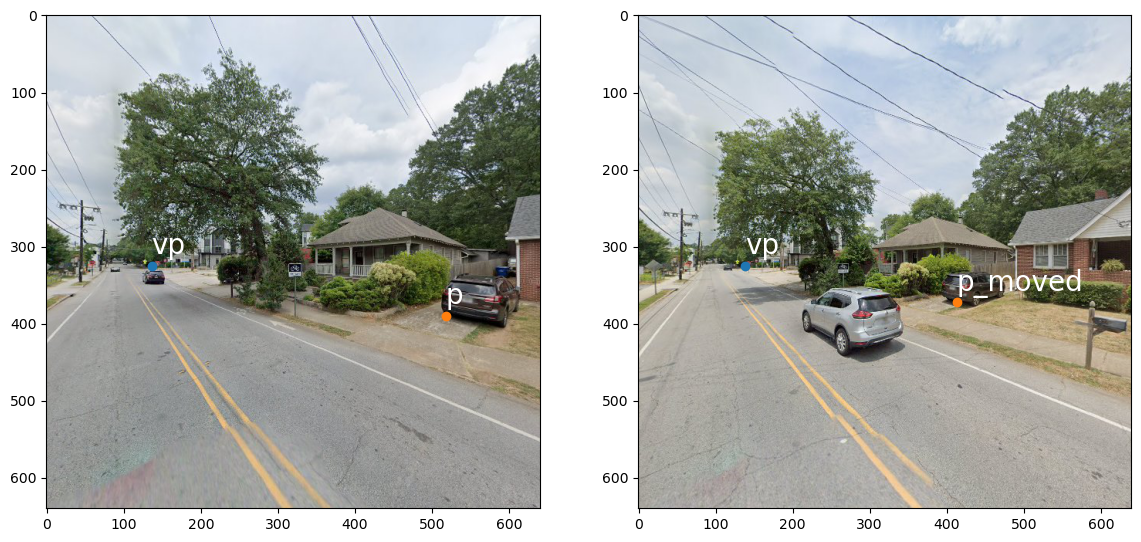

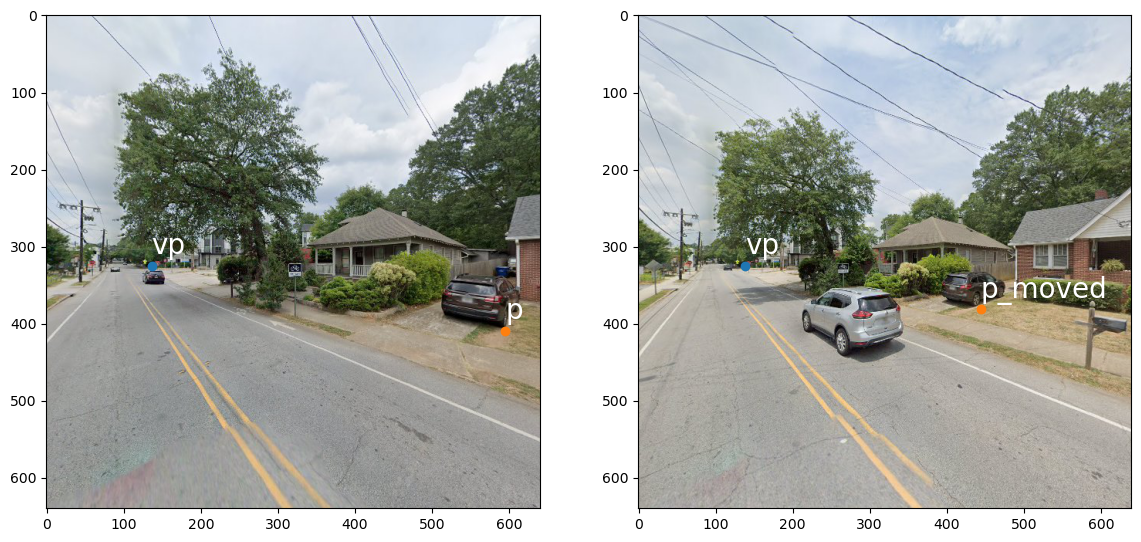

- p_front_proj: (413, 372)
- p_rear_proj: (444, 381)




In [39]:
### Projection sanity check ###
def projectionSanityCheck(img_name, printResult, logResult, headingCalibrate):
    message = []
    runtime = np.array([0., 0., 0., 0.])
    t0 = time.perf_counter()
    rf_adjust = resFovAdjust(res, fov)

    ### 251020: all road segments are two-way
    #leftRight = 'left' if 'left' in f else 'right'
    leftRight = 'left'
    direction = 'to_vp' 

    if printResult:
        print("###### NEW ######")
        print()
     
    side = img_name.split("__")[2]

    cars_on_img = cars_on_street_dict[img_name]
    if printResult:
        print('- number of cars: {}\n- img_name: {}\n- side: {}\n- leftRight: {}\n- direction: {}\n'.format(len(cars_on_img), img_name, side, leftRight, direction))
    if printResult:
        img_path = os.path.join("./vehicle_detection/img_subset", img_name)
        img = plt.imread(img_path) 
        
    t1 = time.perf_counter()
    runtime += np.array([t1-t0, 0., 0., 0.])
    
    for car in cars_on_img:        
        vp = car['vp']
        p_front = car['p_front']
        p_rear = car['p_rear']
        #feature = car["feature"]
    
        if printResult:
            print('- vp: {}\n- p_front: {}\n- p_rear: {}\n'.format(vp, p_front, p_rear))

        t2 = time.perf_counter()

        ###### use the rear wheel unless it is too close from the camera ######
        dist_p_front = pixelToDist(vp, p_front, res, rf_adjust, height) if p_front else float('nan') 
        dist_p_rear = pixelToDist(vp, p_rear, res, rf_adjust, height) if p_rear else float('nan')
        if printResult:
            print(f"- dist_p_front: {dist_p_front:.2f}\n"
                  f"- dist_p_rear : {dist_p_rear :.2f}\n")
                
        ###### ignore objects that is on the other side of the street ######
        if (leftRight == 'left'):
            if (p_front and p_front[0] < vp[0]) or (p_rear and p_rear[0] < vp[0]):
                p_front = []
                p_rear = []
                #message.append('the car is on the other side')
                if printResult:
                    print("### THE CAR IS EITHER ON THE OTHER SIDE OF THE ROAD OR ON THE SAME LANE AS THE STREETVIEW CAR ###")
        else:
            if (p_front and p_front[0] > vp[0]) or (p_rear and p_rear[0] > vp[0]):
                p_front = []
                p_rear = []
                #message.append('the car is on the other side')
                if printResult:
                    print("### THE CAR IS EITHER ON THE OTHER SIDE OF THE ROAD OR ON THE SAME LANE AS THE STREETVIEW CAR ###")
        if printResult:
            print('- p_front: {}\n- p_rear: {}\n'.format(p_front, p_rear))
                    
        t3 = time.perf_counter()
    
        ###### MAIN PART OF PROJECTION ######
        p_front_proj_lr = p_front_proj = p_rear_proj_lr = p_rear_proj = []
    
        dist = []
        
        if p_front:
            dist, p_front_proj_lr, p_front_proj = moveByDistOnPairOfImages(img_name, vp, p_front, res, fov, height, rf_adjust, direction, printResult, logResult, headingCalibrate)
        if p_rear:
            dist, p_rear_proj_lr, p_rear_proj = moveByDistOnPairOfImages(img_name, vp, p_rear, res, fov, height, rf_adjust, direction, printResult, logResult, headingCalibrate)
        if printResult:
            print('- p_front_proj: {}\n- p_rear_proj: {}\n'.format(p_front_proj, p_rear_proj))
            print()
    
        t4 = time.perf_counter()
    
        ###### SAVE RESULTS FOR EACH CAR IN A DICT FORMAT ######
        car['p_front'] = p_front
        car['p_rear'] = p_rear
        car['dist_p_front'] = dist_p_front
        car['dist_p_rear'] = dist_p_rear
        car['dist'] = dist
        car['p_front_proj_lr'] = p_front_proj_lr
        car['p_front_proj'] = p_front_proj
        car['p_rear_proj_lr'] = p_rear_proj_lr
        car['p_rear_proj'] = p_rear_proj
    
        runtime += np.array([0., t2-t1, t3-t2, t4-t3])
        #success = bool(p_front_proj or p_rear_proj)
    return runtime
     
i = randint(0, len(car_img_id_list) - 1)  # Corrected index range
img_name = car_img_id_list[i]
runtime = projectionSanityCheck(img_name, printResult=True, logResult=True, headingCalibrate=True)

In [40]:
for i in range(0, 23):
    try:
        img_name = car_img_id_list[i]
        runtime = projectionSanityCheck(img_name, printResult=False, logResult=False, headingCalibrate=True)
        if i % 1000 == 0:
            print(i, end="//", flush=True)
    except Exception as e:
        print(f"\nError at i={i} ({img_name}): {e}")

#cars_on_street_dict

0//
Error at i=16 (gsv__cluster2_tertiary_27_7__side2__5__2024-06__173.583__33.738739017,-84.343633893.jpg): list index out of range

Error at i=17 (gsv__cluster2_tertiary_27_7__side2__5__2024-06__173.583__33.738739017,-84.343633893.jpg): list index out of range

Error at i=18 (gsv__cluster2_tertiary_27_7__side2__5__2024-06__173.583__33.738739017,-84.343633893.jpg): list index out of range

Error at i=19 (gsv__cluster2_tertiary_27_7__side2__5__2024-06__173.583__33.738739017,-84.343633893.jpg): list index out of range

Error at i=20 (gsv__cluster2_tertiary_27_7__side2__5__2024-06__173.583__33.738739017,-84.343633893.jpg): list index out of range

Error at i=21 (gsv__cluster2_tertiary_27_7__side2__5__2024-06__173.583__33.738739017,-84.343633893.jpg): list index out of range

Error at i=22 (gsv__cluster2_tertiary_27_7__side2__5__2024-06__173.583__33.738739017,-84.343633893.jpg): list index out of range


In [43]:
### Matching ###
def calculateDistance(p0, p1, vp, res, rf_adjust): # do p0 and p1 stand for the predicted and actual points, respectively?
    vp_opposite = getVpPerpendicular(vp, res, rf_adjust)
    p0_on_vpline = p_to_vp_line(p0, vp, vp_opposite) # put a point along the vp using vp_opposite as a reference
    p0_on_vp2line = p_to_vp_line(p0, vp_opposite, vp) # put a point along the vp_opposite using vp as a reference
    p1_on_vpline = p_to_vp_line(p1, vp, vp_opposite)
    p1_on_vp2line = p_to_vp_line(p1, vp_opposite, vp)
    d0_vp = pixelToDist(vp, p0_on_vpline, res, rf_adjust, height)
    d0_vp_opposite = pixelToDist(vp_opposite, p0_on_vp2line, res, rf_adjust, height)
    d1_vp = pixelToDist(vp, p1_on_vpline, res, rf_adjust, height)
    d1_vp_opposite = pixelToDist(vp_opposite, p1_on_vp2line, res, rf_adjust, height)
    d_p0_to_p1_option2 = ((d0_vp - d1_vp)**2 + (d0_vp_opposite - d1_vp_opposite)**2)**(1/2)
    return [round(abs(d0_vp - d1_vp), 2), round(abs(d0_vp_opposite - d1_vp_opposite), 2), d_p0_to_p1_option2]

def cosineSimilarity(f1, f2):
    f1_norm = f1 / np.linalg.norm(f1)
    f2_norm = f2 / np.linalg.norm(f2)
    cos_sim = torch.mm(f1_norm, f2_norm.t()).numpy()
    return float(cos_sim)
    
rf_adjust = resFovAdjust(res, fov)
log = {'match_found':0, 'match_not_found':0, 'front_to_rear_update':0, 'p_too_far':0, 'last_image':0, 'p_front_not_exist':0, 'p_rear_not_exist':0, 'no_car_in_next_image':0}

for img_num in tqdm(range(len(car_img_id_list))):
    cur_img = car_img_id_list[img_num]
    cur_leftRight = 'left' if 'left' in cur_img else 'right'
    cur_cars = cars_on_street_dict[cur_img]

    for car_num in range(len(cur_cars)):
        cur_car = cur_cars[car_num]
        cur_car['matching_wheel'] = []
        cur_car['p_actual'] = []
        cur_car['dist_error'] = []
        cur_car['dist_road_direction'] = []
        cur_car['dist_side_direction'] = []
        cur_car['cosine_similarity'] = []
        cur_car['matching_status_as_cur'] = False

        placeholder_keys = [
            'p_front','p_rear',
            'dist_p_front','dist_p_rear',
            'p_front_proj_lr','p_front_proj',
            'p_rear_proj_lr','p_rear_proj',
        ]
        for key in placeholder_keys:
            cur_car.setdefault(key, [])
            
        try:
            cur_car['matching_id']
        except KeyError:
            cur_car['matching_id'] = []
        try: 
            cur_car['matching_status_as_next']
        except KeyError:
            cur_car['matching_status_as_next'] = False

        vp = cur_car["vp"]
        
        if not (cur_car.get('p_front') or cur_car.get('p_rear')):
            continue
            
        if not cur_car.get('p_rear'):
            p_wheel = 'p_front'
        else:
            p_wheel = 'p_rear'
            
        if cur_car[p_wheel] and cur_car[p_wheel + '_proj']:   # find the next image on the next step, also considering the direction, if applicable            
            roadseg_id = cur_img.split("__")[0] + "__" + cur_img.split("__")[1]
            roadseg_list = [img for img in car_img_id_list if roadseg_id in img]
            
            side1_files = sorted([f for f in roadseg_list if 'side1' in f], key=lambda x: int(re.search(r'side1__(\d+)', x).group(1)), reverse=True)
            if cur_leftRight == "right":
                side2_files = sorted([f for f in roadseg_list if 'side2' in f], key=lambda x: int(re.search(r'side2__(\d+)', x).group(1)), reverse=True)
            else: 
                side2_files = sorted([f for f in roadseg_list if 'side2' in f], key=lambda x: int(re.search(r'side2__(\d+)', x).group(1)), reverse=False)
    
            side1_next = {side1_files[i]: side1_files[i + 1] if i + 1 < len(side1_files) else None for i in range(len(side1_files))}
            side2_next = {side2_files[i]: side2_files[i + 1] if i + 1 < len(side2_files) else None for i in range(len(side2_files))}
            
            side_group = side1_next if "side1" in cur_img else side2_next
            next_img = side_group.get(cur_img)
        else:
            log[p_wheel +'_not_exist'] += 1
            continue

        if cur_car['dist_' + p_wheel] > 40:
            log['p_too_far'] += 1
            continue
        if next_img not in car_img_id_list:
            log['no_car_in_next_image'] += 1
            continue
        else:
            # for the next image, we accumulate info of multiple cars in the image in one dictionary
            next_cars = cars_on_street_dict[next_img]
            next_car_dict = {'p':[], 'feature':[], 'dist_error':[], 'similarity':[], 'dist_road_direction':[], 'dist_side_direction':[]}

            # this part might be revised with a less strict criterion, if using fewer images per road segment. currently it is decided by dist_diff >0 in moveByDistOnPairOfImages()
            for next_car in next_cars:
                next_car_dict['feature'].append(next_car['feature'])
                if cur_leftRight != cur_car[p_wheel + '_proj_lr']: # whether the wheel is projected to be on the same or other direction (L/R) on the next step
                    p_opposite = 'p_front' if p_wheel == 'p_rear' else 'p_rear'
                    next_car_dict['p'].append(next_car.get(p_opposite)) # if projected to be on the other direction, you should look for the other wheel (b/c better sight)
                else:
                    next_car_dict['p'].append(next_car.get(p_wheel)) # if projected to be on the same direction, you can keep track of the same wheel

            for i in range(len(next_cars)):
                p0 = cur_car[p_wheel + '_proj']
                p1 = next_car_dict['p'][i]
                #print(f"p0: {p0}")
                #print(f"p1: {p1}")

                # 251027
                #if next_car_dict['p'][i]:
                #    d_road, d_side, d = calculateDistance(cur_car[p_wheel + '_proj'], next_car_dict['p'][i], vp, res, rf_adjust) # comparing the projected and the actual
                if isinstance(p0, (list, tuple)) and isinstance(p1, (list, tuple)) and len(p0) == 2 and len(p1) == 2:

                    d_road, d_side, d = calculateDistance(p0, p1, vp, res, rf_adjust)
                    next_car_dict['dist_road_direction'].append(d_road)
                    next_car_dict['dist_side_direction'].append(d_side)
                    next_car_dict['dist_error'].append(d)
                    next_car_dict['similarity'].append(cosineSimilarity(cur_car['feature'], next_cars[i]['feature']))

                else: # just fill in empty elements to ensure that the dictionary is in full shape and so easy to call
                    print(f"[Warning] Skipped distance calc for {img_name}: invalid p0/p1 values {p0}, {p1}")
                    next_car_dict['dist_road_direction'].append([])
                    next_car_dict['dist_side_direction'].append([])
                    next_car_dict['dist_error'].append([])
                    next_car_dict['similarity'].append([])

            # retrieve the ones that are matched
            match = []
            for i in range(len(next_car_dict['p'])):
                if next_car_dict['dist_error'][i]: # newly calculated error distance between predicted and actual
                    
                    # if next_car_dict['dist_error'][i] < distance_threshold_meter and next_car_dict['similarity'][i] > similarity_threshold: 
                    # not going to use these two thresholds 
                    # give the status of "match" as long as the projections have been made on that car
                    match.append(i)

            # have to relax this criterion if want to see more pairs
            if len(match) > 1:
                match = next_car_dict['similarity'].index(max([next_car_dict['similarity'][i] for i in match]))  # find the index of the car with the highest similarity
            elif len(match) == 1:
                match = match[0]

            if match:
                log['match_found'] += 1
                distance_got_shorter = False 
                if cur_car['matching_wheel']:
                    distance_got_shorter = cur_car['dist_error'] > next_car_dict['dist_error'][match]
                if distance_got_shorter:
                    log['front_to_rear_update'] += 1 if distance_got_shorter else 0  # Yes, it seems right. 

                if not cur_car['matching_status_as_cur'] or (distance_got_shorter): # if never has been matched before or just has gotten a smaller error distance
                    cur_car['matching_wheel'] = p_wheel
                    cur_car['p_actual'] = next_car_dict['p'][match]
                    cur_car['dist_error'] = next_car_dict['dist_error'][match]
                    cur_car['dist_road_direction'] = next_car_dict['dist_road_direction'][match]
                    cur_car['dist_side_direction'] = next_car_dict['dist_side_direction'][match]
                    cur_car['cosine_similarity'] = next_car_dict['similarity'][match]

                    if cur_car['matching_status_as_next']:  # if the current car has been matched before from the previous trial, then 
                        next_cars[match]['matching_id'] = cur_car['matching_id']
                    else:
                        next_cars[match]['matching_id'] = cur_car['matching_id'] = randint(0, 100000000)

                    # once matched for the front wheel then assign True for either the current or the next car
                    cur_car['matching_status_as_cur'] = True 
                    next_cars[match]['matching_status_as_next'] = True
            else:
                log['match_not_found'] += 1
        print(cur_car['cosine_similarity'])
    print("====new image====")

  0%|                                                                                                                                          | 0/16 [00:00<?, ?it/s]/tmp/ipykernel_2147341/1740362037.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(cos_sim)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 11382.10it/s]

====new image====
====new image====
====new image====
====new image====
====new image====
[Warning] Skipped distance calc for gsv__cluster2_tertiary_27_7__side2__5__2024-06__173.583__33.738739017,-84.343633893.jpg: invalid p0/p1 values (187, 369), []
[]
====new image====
====new image====
====new image====
[]
====new image====
====new image====
====new image====
[]
[]
====new image====
[]
[]
====new image====
0.8762513399124146
====new image====
[]
====new image====
====new image====


In [44]:
### Extract results ###
mr = copy.deepcopy(cars_on_street_dict)
for img in mr:
    for cars in mr[img]:
        del cars['feature']

mr_keys_list = list(mr.keys())
mr_keys_list = sorted(mr_keys_list)

img = mr[mr_keys_list[0]]
car = img[0] # the first car in the image as an example
keys_to_retrieve = list(car.keys())
print(len(keys_to_retrieve))
print(keys_to_retrieve)

concat_list = []

for img in mr:
    for i, car in enumerate(mr[img]): 
        car_info = [car.get(key, []) for key in keys_to_retrieve]
        car_info = pd.Series(car_info)
        img_carspecific_name = "__".join(img.split("__")[1:4]) 
        img_carspecific_name = img_carspecific_name + "__" + str(i)
        car_info.name = img_carspecific_name
        concat_list.append(car_info)

mr_df = pd.concat(concat_list, axis=1)
mr_df.index = [key for key in keys_to_retrieve]
mr_df = mr_df.T
mr_df[mr_df.applymap(lambda x: isinstance(x, list) and len(x)==0)] = None
mr_df["matching_id"] = mr_df["matching_id"].astype(str)

mr_df["dist_p_front"] = pd.to_numeric(mr_df["dist_p_front"], errors="coerce")
mr_df["dist_p_rear"] = pd.to_numeric(mr_df["dist_p_rear"], errors="coerce")
mr_df["dist"] = pd.to_numeric(mr_df["dist"], errors="coerce")
mr_df["dist_road_direction"] = pd.to_numeric(mr_df["dist_road_direction"], errors="coerce")
mr_df["dist_side_direction"] = pd.to_numeric(mr_df["dist_side_direction"], errors="coerce")
mr_df["cosine_similarity"] = pd.to_numeric(mr_df["cosine_similarity"], errors="coerce")
mr_df["dist_error"] = pd.to_numeric(mr_df["dist_error"], errors="coerce")
mr_df

print(len(mr_df))
mr_df.iloc[0:3]

19
['vp', 'p_front', 'p_rear', 'dist_p_front', 'dist_p_rear', 'dist', 'p_front_proj_lr', 'p_front_proj', 'p_rear_proj_lr', 'p_rear_proj', 'matching_wheel', 'p_actual', 'dist_error', 'dist_road_direction', 'dist_side_direction', 'cosine_similarity', 'matching_status_as_cur', 'matching_id', 'matching_status_as_next']
18


/tmp/ipykernel_2147341/1509411770.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mr_df[mr_df.applymap(lambda x: isinstance(x, list) and len(x)==0)] = None


,vp,p_front,p_rear,dist_p_front,dist_p_rear,dist,p_front_proj_lr,p_front_proj,p_rear_proj_lr,p_rear_proj,matching_wheel,p_actual,dist_error,dist_road_direction,dist_side_direction,cosine_similarity,matching_status_as_cur,matching_id,matching_status_as_next
cluster2_secondary_15_6__side1__4__0,"[131, 318]","[350, 339]","[418, 345]",32.147641,26.448009,NaN,left,[no next image available],left,[no next image available],None,None,NaN,NaN,NaN,NaN,False,None,False
cluster2_secondary_15_6__side2__0__0,"[139, 321]","[397, 365]","[426, 365]",15.881171,16.412361,NaN,left,[no next image available],left,[no next image available],None,None,NaN,NaN,NaN,NaN,False,None,False
cluster2_secondary_31_17__side1__3__0,"[137, 309]","[451, 443]",None,5.469346,NaN,NaN,left,[no next image available],None,None,None,None,NaN,NaN,NaN,NaN,False,None,False


In [50]:
### Cut off ###
mr_df_valid = mr_df.loc[
        (mr_df["matching_id"].notna()) &
        (mr_df["dist_error"].notna()) &
        (mr_df["cosine_similarity"].notna()),
        ["vp", "p_front", "p_rear", "p_front_proj", "p_rear_proj",
         "matching_id", "dist_error", "cosine_similarity"]
        ]

mr_df_valid["matching_id"] = mr_df_valid["matching_id"].astype(int).astype(str)
print(mr_df_valid.shape)
print(mr_df_valid.iloc[0:2])
print()

def cutoff(distance_threshold_meter, similarity_threshold):
    print(f'distance_threshold_meter: {distance_threshold_meter}')
    print(f'similarity_threshold: {similarity_threshold}')

    mr_df_valid_cutoffed = mr_df_valid.loc[
        (mr_df["dist_error"] < distance_threshold_meter) &
        (mr_df["cosine_similarity"] > similarity_threshold),
        ["matching_id", "dist_error", "cosine_similarity"]
        ]
    return mr_df_valid_cutoffed

distance_threshold_meter_list = [9]
similarity_threshold_list = [0.6]

for cutoff_dist in distance_threshold_meter_list:
    for cutoff_sim in similarity_threshold_list:
        mr_df_valid_cutoffed = cutoff(cutoff_dist, cutoff_sim)
        
mr_df_valid_cutoffed = mr_df_valid_cutoffed.reset_index()
mr_df_valid_cutoffed

(1, 8)
                                             vp     p_front      p_rear  \
cluster2_tertiary_27_7__side1__3__0  [136, 325]  [518, 390]  [595, 409]   

                                    p_front_proj p_rear_proj matching_id  \
cluster2_tertiary_27_7__side1__3__0   (413, 372)  (444, 381)    22585187   

                                     dist_error  cosine_similarity  
cluster2_tertiary_27_7__side1__3__0    3.829481           0.876251  

distance_threshold_meter: 9
similarity_threshold: 0.6


,matching_id,dist_error,cosine_similarity
cluster2_tertiary_27_7__side1__3__0,22585187,3.829481,0.876251


In [47]:
# from matplotlib.ticker import ScalarFormatter

# data = mr_df_valid
# #data = mr_df_valid[(mr_df_valid['dist_error'] < 20) & (mr_df_valid['cosine_similarity'] > 0.1)] 
# print(len(data))
# data1 = data['dist_error']
# data2 = data['cosine_similarity']

# # Create 1×2 subplots without shared y-axis
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # Removed sharey=True

# # First histogram (<20)
# ax1.hist(data1, bins=30)
# ax1.set_title('Projection Distance Error (m)')
# ax1.set_xlabel('Distance (m)')
# ax1.set_ylabel('Count')
# ax1.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
# ax1.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
# ax1.ticklabel_format(style='plain', axis='both')

# # Second histogram (cosine similarity)
# ax2.hist(data2, bins=20)
# ax2.set_title('Cosine Similarity')
# ax2.set_xlabel('Cosine Similarity')
# ax2.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
# ax2.ticklabel_format(style='plain', axis='both')

# plt.tight_layout()
# plt.show()

In [56]:
### Export ###
output_path = os.path.join(WORK_DIR, "vehicle_detection_result.csv")
mr_df_valid_cutoffed.to_csv(output_path, index=True)